In [1]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [2]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [3]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type

In [4]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/train_timeseries.csv'

df = pd.read_csv(file_path)
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head()

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Feature Engineering

In [6]:
def log_feature(val):
    result = np.log(val)
    
    if result not in [np.inf, -np.inf, np.NaN]:
        return result
    else:
        return 0

In [7]:
def devide_feature(val):
    if val[1] == 0:
        return 0
    else:
        return val[0]/val[1]

In [8]:
# Add log feature
df['AirTempLog'] = (df['AirTemp']).transform(log_feature)
df['ProcessTempLog'] = (df['ProcessTemp']).transform(log_feature)
df['RotationalSpeedLog'] = (df['RotationalSpeed']).transform(log_feature)
df['TorqueLog'] = (df['Torque']).transform(log_feature)
df['ToolWearLog'] = (df['ToolWear']).transform(log_feature)

In [9]:
# Add devided feature

df['AirTempProcessTempDevided'] = (df[['AirTemp', 'ProcessTemp']]).apply(devide_feature, axis=1)
df['TorqueRotationalSpeedDevided'] = (df[['Torque', 'RotationalSpeed']]).apply(devide_feature, axis=1)

In [10]:
# Add square feature

df['AirTempSq'] = (df['AirTemp']) * (df['AirTemp'])
df['ProcessTempSq'] = (df['ProcessTemp']) * (df['ProcessTemp'])
df['RotationalSpeedSq'] = (df['RotationalSpeed']) * (df['RotationalSpeed'])
df['TorqueSq'] = (df['Torque']) * (df['Torque'])
df['ToolWearSq'] = (df['ToolWear']) * (df['ToolWear'])

In [13]:
df['Airtemp_Class'] = encode_feature(df['AirTemp'])
df['ProcessTemp_Class'] = encode_feature(df['ProcessTemp'])
df['Rotational_Class'] = encode_feature(df['RotationalSpeed'])
df['Torque_Class'] = encode_feature(df['Torque'])
df['ToolWear_Class'] = encode_feature(df['ToolWear'])

In [14]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,...,AirTempSq,ProcessTempSq,RotationalSpeedSq,TorqueSq,ToolWearSq,Airtemp_Class,ProcessTemp_Class,Rotational_Class,Torque_Class,ToolWear_Class
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,88863.61,95233.96,2405601,1831.84,0,c,c,e,e,c
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,88923.24,95295.69,1982464,2143.69,9,c,d,d,e,c


In [15]:
def plot_class_distribution(df, label):
    c = ['Grey', 'Red']
    df.groupby('MF').size().plot(kind="bar", color=c)
    plt.title('Class Distribution', fontsize=18)
    plt.yticks(np.arange(0, 12000, 2000))
    # plt.grid()

    for index, value in enumerate(df.groupby(label).size()):
        c_label = ''
        if index == 0:
            c_label = 'Black'
        else:
            c_label = 'Red'
        plt.text(index - 0.1, value + 1000, str(value), color=c_label, fontsize=14)

    sns.despine()

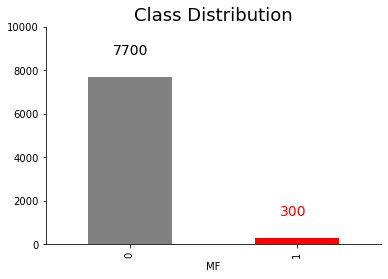

In [18]:
plot_class_distribution(df, 'MF')

# Genetic Algorithms to find the prediction pattern

## encoder function

In [12]:
# This function use to encode data point to be class label
# a = data less than or equal percentile 25
# b = data less than or equal percentile 50
# c = data less than or equal percentile 75
# d = data greater than percentile 75

def encode_feature(df):
    
    mean = np.mean(df)
    std = np.std(df)
    
    encoder_list = []
    
    for data_point in df:
        
        if data_point <= (mean - (3*std)):
            encoder_list.append('a')
            continue
        
        if data_point <= (mean - (2*std)):
            encoder_list.append('b')
            continue
            
        if data_point <= (mean - (1*std)):
            encoder_list.append('c')
            continue
            
        if data_point <= mean:
            encoder_list.append('d')
            continue
            
        if data_point <= (mean + (1*std)):
            encoder_list.append('e')
            continue
            
        if data_point <= (mean + (2*std)):
            encoder_list.append('f')
            continue       
                        
        encoder_list.append('g')

    return encoder_list

In [16]:
print(df['Torque'])
df_torque = df['Torque']

test_encoder = encode_feature(df_torque)
test_encoder[:10]

0       42.8
1       46.3
2       49.4
3       39.5
4       40.0
        ... 
7995    28.8
7996    41.5
7997     9.7
7998    51.7
7999    31.0
Name: Torque, Length: 8000, dtype: float64


['e', 'e', 'e', 'd', 'e', 'e', 'e', 'e', 'c', 'c']

### Generate the random genome by specific length

In [25]:
def generate_genome(length:int,num_group=1):
    
    
    previous_gene = ''
    or_logic = False
    count_or = 0
    genome_group = []
    
    for j in range(num_group):
        
        genome = []
        for i in range(length):

            # First character should not be symbol
            if i == 0:
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # Last character should not be symbol
            if i == (length-1):
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                continue

            # If previous character is symbol then next character should not be symbol
            if previous_gene[0] == '.*' or previous_gene[0] == '|':
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene

                if previous_gene[0] == '|':
                    or_logic = True
                    count_or = 2

                previous_gene = next_gene
                continue

            if count_or > 0:
                next_gene = choices(['a','b','c','d','e','f','g'], k=1)
                genome = genome + next_gene
                previous_gene = next_gene
                count_or = count_or - 1
                continue

            next_gene = choices(['a','b','c','d','e','f','g','.*','|'], k=1)            
            genome = genome + next_gene
            previous_gene = next_gene
        genome_group.append(genome) 
    
    return genome_group

In [24]:
test_genome = generate_genome(5,2)
test_genome

[['b', 'e', 'b', 'a', 'c'], ['g', 'e', 'a', '|', 'g']]

### Generate the population

In [23]:
def generate_population(size, genome_lenght, num_group=1):
    return [generate_genome(genome_lenght, num_group) for _ in range(size)]

In [24]:
test_population = generate_population(3, 5, 2)
test_population

[[['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['f', 'f', '|', 'e', 'c'], ['g', 'd', 'e', 'e', 'a']],
 [['d', '|', 'b', 'f', 'f'], ['d', 'c', 'b', 'a', 'b']]]

### Get expression

In [19]:
def get_expression(data, num_group):
    
    
    or_flag = False
    expression_group = []
    
    for j in range(num_group):
        reg_result = ""
        
        for idx, i in enumerate(data[j]):

            if i == '|' and reg_result == "":
                raise Exception(f"The symbol '|' can't be the first parameter: {data}")

            if i == '|' and (idx + 1) == len(data[j]):
                raise Exception(f"The symbol '|' can't be the last parameter: {data}")

            if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == False:
                reg_result = reg_result + i
                buf = i
                continue

            if i in ('a', 'b', 'c', 'd','e','f','g','.*') and or_flag == True:
                reg_result = reg_result + f"{i}]"
                or_flag = False
                continue

            if or_flag == True and (i == '|' or i == '.*'):
                reg_result = reg_result + 'd'
                continue

            if i == '|':
                reg_result = reg_result[0:(len(reg_result)- len(buf))]
                reg_result = reg_result + f"[{buf}|"
                or_flag = True
                continue
                
        expression_group.append('.*'+reg_result+".*")
 
    return expression_group

In [23]:
test_expression = get_expression(test_genome, 2)

print(test_genome)
print(test_expression)

[['b', 'a', '.*', 'c', 'd'], ['f', 'c', 'c', 'a', 'a']]
['.*ba.*cd.*', '.*fccaa.*']


### Encoded feature fortesting

In [28]:
df_MF = df['MF']

df_torque = df['Torque']
df_speed = df['RotationalSpeed']
df_airtemp = df['AirTemp']
df_processtemp = df['ProcessTemp']
df_toolwear = df['ToolWear']

encoded_torque = encode_feature(df_torque)
encoded_speed = encode_feature(df_speed)
encoded_airtemp = encode_feature(df_airtemp)
encoded_processtemp = encode_feature(df_processtemp)
encoded_toolwear = encode_feature(df_toolwear)

encoded_features = [encoded_torque, encoded_speed, encoded_airtemp, encoded_processtemp, encoded_toolwear]

### Calculate the fitness score

In [27]:
def fitness(genome, encoder_results, df_state, window_size=20, is_print_counting = False, num_group=2):
    
    # Initial setting for window
    start = 0
    end = window_size
    number_round = int(len(encoder_results[0])/window_size)-1
    
    has_match_pattern = False
    
    fitness_score = 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    # Parameter for counting
    count_predict_true = 0
    count_predict_false = 0
    count_not_match = 0
    
    # Get reg function from genome
    reg_expressions = get_expression(genome, num_group)
    
    predict_list = []
    
    # Iterate over the data by specific period
    for i in range(0, number_round):
        
        # Start by pattern doesn't matched
        predict_fail = False 
        
        # Get current pattern of feature
        for encoder_result in encoder_results:
            if predict_fail == True:
                continue
        
            current_pattern = ''.join(encoder_result[start:end])
        
            for reg_expression in reg_expressions:
                if predict_fail == True:
                    continue

                matched = re.search(reg_expression, current_pattern)

                if matched is not None:
                    predict_fail = True

                    if has_match_pattern == False:
                        has_match_pattern = True
                else:
                    predict_fail = False
        

        
        # Find the next period will have the fail case or not
        fail_next_period = list(df_state[end:end+window_size])
        is_fail_next_period = sum(fail_next_period)>0
    
        # Calculate Fitness Score
        if  predict_fail == True and is_fail_next_period == True:
            TP += 1
            
        if predict_fail == True and is_fail_next_period == False:
            FP += 1
            
        if predict_fail == False and is_fail_next_period == False:
            TN += 1
            
        if predict_fail == False and is_fail_next_period == True:
            FN += 1
            
            

        start += window_size
        end += window_size
        
    # Calculate accuracy
    if (TN + FP + TP + FN) == 0:
        accuracy = 0
    else:
        accuracy = (TN + TP)/(TN + FP + TP + FN)
        
    # Calculate recall    
    if (TP+FN) == 0:
        recall = 0
    else:
        recall = TP/(TP + FN)
    
    # Calculate precision
    if (TP+FP) == 0:
        precision = 0
    else:
        precision = TP/(TP+FP)
    
    # Calculate f1 score
    if (precision+recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * ((precision * recall)/(precision+recall))
    
    if is_print_counting == True:
        print(f'Count True: {count_predict_true}, False: {count_predict_false}, Not match: {count_not_match}')
    
    return(f1_score, accuracy, precision, recall)

In [29]:
df_MF = df['MF']

df_PWF = df['PWF']  
df_HDF = df['HDF'] --> Alarm จากปัญหาอะไร

# --> Random Forest to find importance 
# --> Alarm จากปัญหาอะไร
# --> เก็บว่า TP มาจาก encoded ตัวไหน

df_torque = df['Torque']
df_rotatiional_speed = df['RotationalSpeed']

encoded_torque = encode_feature(df_torque)
encoded_rotatiional_speed = encode_feature(df_rotatiional_speed)

encoder_results = [encoded_torque, encoded_rotatiional_speed]

SyntaxError: invalid syntax (<ipython-input-29-686a9f8bdb50>, line 3)

In [22]:
test_genome = generate_genome(length=5, num_group=2)

f1_score, accuracy, precision, recall = fitness(test_genome, encoder_results, df_MF, 40)
print(recall)

NameError: name 'encoder_results' is not defined

### Selection Pair

In [31]:
def selection_pair(population, weights, number=10):
    return choices(
        population=population,
        weights= weights,
        k=number
    )

In [32]:
test_population

[[['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['f', 'f', '|', 'e', 'c'], ['g', 'd', 'e', 'e', 'a']],
 [['d', '|', 'b', 'f', 'f'], ['d', 'c', 'b', 'a', 'b']]]

In [33]:
weights = [1, 0, 0]
selected_genome = selection_pair(test_population, weights)
selected_genome

[[['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']],
 [['a', 'c', 'c', 'c', 'f'], ['f', '.*', 'b', 'b', 'e']]]

### Cross Over

In [34]:
def single_point_cross_over(genome1, genome2, num_group=2):
    
    genome_result1 = []
    genome_result2 = []

    
    for i in range(num_group):
        if len(genome1[i]) != len(genome2[i]):
            print(genome1[i])
            print(genome2[i])
            raise ValueError("Genomes 1 and 2 must be of same length")

        length = len(genome1[i])

        if length < 2:
            offspring1 = genome1[i]
            offspring2 = genome2[i]

        if length >= 2:    
            position = randint(1, length-1)
            offspring1 = genome1[i][0:position] + genome2[i][position:]
            offspring2 = genome2[i][0:position] + genome1[i][position:]
        
        genome_result1.append(offspring1)
        genome_result2.append(offspring2)
        
    return genome_result1, genome_result2

In [35]:
test_genome1 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10], [11,12,13,14,15]]
test_genome2 = [[15,14,13,12,11],[10, 9 , 8, 7, 6], [5, 4, 3, 2, 1]]

print(single_point_cross_over(test_genome1, test_genome2, num_group=3))

([[1, 2, 13, 12, 11], [6, 7, 8, 7, 6], [11, 12, 13, 2, 1]], [[15, 14, 3, 4, 5], [10, 9, 8, 9, 10], [5, 4, 3, 14, 15]])


### Mutation

In [36]:
def mutation(genome, number=1, num_group=2):
    for i in range(num_group):
        for _ in range(number):
            index = randrange(len(genome[i]))
            genome[i][index] = choices(['a','b','c','d','e','f','g'], k=1)[0]

    return genome

In [37]:
test_genome3 = [[1, 2, 3, 4 ,5], [6, 7, 8, 9, 10]]
new = mutation(test_genome3)
new

[[1, 2, 3, 'd', 5], [6, 7, 'c', 9, 10]]

### Evolution

In [47]:
def run_evolution(encoded_feature, df_state,window_size, generation_limit=100, population_size=10, genome_length=10, num_group=2):
    
    # Parameter setting
    pop_crossover_threshold = 0.80
    pop_mutation_threshold = 0.02
    
    # --------------------------------------- 1. Generate Population --------------------------------------- #
    population = generate_population(size=population_size, genome_lenght=genome_length, num_group=num_group)
    
    for i in range(generation_limit):
        
        # 1. Calculate fitness score for all population
        # f1_score:0, accuracy:1, precision:2, recall:3
        fitness_scores = [fitness(genome, encoded_feature, df_state=df_state, window_size=window_size, is_print_counting=False, num_group=num_group)[0] for genome in population]

        max_score = max(fitness_scores)
        
        if False:
            print(f'round {i} has max score {max_score}.')  #The whole score list {fitness_scores}')

        # 2. Evaluation
        if max_score >= 0.8:
            population_and_score = list(zip(score, population))
            sorted_population_and_score = population_and_score.sort(reverse=True)
            top_population = sorted_population_and_score[0]
            print(f"The best population is {top_population[1]} with score {top_population[0]}")
            break

        # 3. Select new population
        
        if sum(fitness_scores) == 0:
            new_population = population
            #print(f'score is zero')
            #print(fitness_scores)
            #print(population)
        else:
            adjust_score = [i for i in fitness_scores]
            weight_selection = [i/sum(adjust_score) for i in adjust_score] # Weight for random new population
            new_population = selection_pair(population, weight_selection, 10)

        # 4. Crossover
        offspring = []
        
        all_idx = list(range(len(new_population)))
        
        for idx, genome in enumerate(new_population):
            
            # Check index doesn't use yet
            if idx not in all_idx:
                continue
                
            # Remove the index of genome
            all_idx.remove(idx)
            
            # Get random index of other genome
            random_idx = choices(all_idx)[0]
            other_genome = new_population[random_idx]
            
            # Remove the index of other genome
            all_idx.remove(random_idx)
            
            # Check pop to cross over
            pop_crossover = uniform(0, 1)

            if pop_crossover <= pop_crossover_threshold:
                offspring1, offspring2 = single_point_cross_over(genome, other_genome, num_group=num_group)
            else:
                offspring1, offspring2 = genome, other_genome
                    
            offspring.append(offspring1)
            offspring.append(offspring2)

        new_population = offspring.copy()

        # 5. Mutation
        for idx, genome in enumerate(new_population):
            pop_mutation = uniform(0, 1)
            if pop_mutation <= pop_mutation_threshold: 
                new_population[idx] = mutation(genome, num_group=num_group)
        
        population = new_population
        
        # 6. Exist loop when exceed the generation_limit
        if i == generation_limit - 1:
            fitness_scores = [fitness(genome, encoded_feature, df_state=df_state, window_size=window_size, is_print_counting=False, num_group=num_group)[0] for genome in population]
            population_and_score = list(zip(fitness_scores, population))
            population_and_score.sort(reverse=True)
            top_population = population_and_score[0]
            
            f1_score, accuracy, precision, recall = fitness(top_population[1], encoded_feature, df_state=df_state, window_size=20, is_print_counting=False, num_group=num_group)
            #print(f"Last round the best population is {top_population[1]} with score {top_population[0]}")
            
    return(top_population[1], f1_score, accuracy, precision, recall)
        

In [48]:
df_MF = df['MF']

df_torque = df['Torque']
df_speed = df['RotationalSpeed']
df_airtemp = df['AirTemp']
df_processtemp = df['ProcessTemp']
df_toolwear = df['ToolWear']

encoded_torque = encode_feature(df_torque)
encoded_speed = encode_feature(df_speed)
encoded_airtemp = encode_feature(df_airtemp)
encoded_processtemp = encode_feature(df_processtemp)
encoded_toolwear = encode_feature(df_toolwear)

encoded_features = [encoded_torque, encoded_speed, encoded_airtemp, encoded_processtemp, encoded_toolwear]

In [87]:
top_population, f1_score, accuracy, precision, recall = run_evolution(
    encoded_feature=encoded_features,
    window_size=18,
    df_state=df_MF,
    generation_limit=10000,
    population_size=10,
    genome_length=6,
    num_group=8,)

### Generate Report

In [81]:
def generate_report(max_pattern_group, max_pattern_length, num_loop, window_sizes):
    df_report = pd.DataFrame(columns = ['window_size','num_group','pattern_length','Pattern','F1','Accuracy','Precision','Recall'])
                             
    for num_group in range(1,max_pattern_group+1):
        for genome_length in range(2,max_pattern_length+1):
            for window_size in window_sizes:
                
                if genome_length >= window_size:
                    continue
            
                top_population, f1_score, accuracy, precision, recall = run_evolution(
                    encoded_feature=encoded_features,
                    window_size=window_size,
                    df_state=df_MF,
                    generation_limit=num_loop,
                    population_size=10,
                    genome_length=genome_length,
                    num_group=num_group,)
            
                data = [window_size,num_group,genome_length, top_population, f1_score, accuracy, precision, recall]

                try:
                    df_report.loc[len(df_report)] = data
                    print(f'complete for window_size {window_size} number_group {num_group} and genome_length {genome_length}.')
                except Exception as e:
                    print(f'error for window_size {window_size}  number_group {num_group} and genome_length {genome_length}.')
                    print('*'*50)
                    print(e)
                    print('*'*50)
                
    return df_report
                             
                             
    

In [82]:
result = generate_report(
    max_pattern_group=20,
    max_pattern_length=20,
    window_sizes= [6, 8, 10, 12, 14, 16, 18, 20],
    num_loop=50
)

complete for window_size 6 number_group 1 and genome_length 2.
complete for window_size 8 number_group 1 and genome_length 2.
complete for window_size 10 number_group 1 and genome_length 2.
complete for window_size 12 number_group 1 and genome_length 2.
complete for window_size 14 number_group 1 and genome_length 2.
complete for window_size 16 number_group 1 and genome_length 2.
complete for window_size 18 number_group 1 and genome_length 2.
complete for window_size 20 number_group 1 and genome_length 2.
complete for window_size 6 number_group 1 and genome_length 3.
complete for window_size 8 number_group 1 and genome_length 3.
complete for window_size 10 number_group 1 and genome_length 3.
complete for window_size 12 number_group 1 and genome_length 3.
complete for window_size 14 number_group 1 and genome_length 3.
complete for window_size 16 number_group 1 and genome_length 3.
complete for window_size 18 number_group 1 and genome_length 3.
complete for window_size 20 number_group 1 a

In [93]:
result.sort_values(by=['F1'], ascending=False).head(30)

,window_size,num_group,pattern_length,Pattern,F1,Accuracy,Precision,Recall
653,18,8,6,"[[b, e, d, c, |, b], [a, f, f, |, f, g], [d, a...",0.627615,0.553885,0.485437,0.887574
930,18,11,8,"[[e, c, |, a, c, f, |, c], [e, f, |, e, e, g, ...",0.620278,0.521303,0.467066,0.923077
1551,16,18,9,"[[b, b, c, c, c, b, c, c, g], [d, a, c, f, d, ...",0.620253,0.548872,0.481967,0.869822
916,16,11,6,"[[d, .*, c, g, e, f], [c, b, a, |, .*, g], [c,...",0.619658,0.553885,0.484950,0.857988
482,14,6,7,"[[e, f, |, e, e, e, e], [e, b, c, b, |, g, a],...",0.617647,0.543860,0.478827,0.869822
228,10,3,9,"[[e, .*, g, |, e, e, e, e, e], [e, e, e, g, d,...",0.616702,0.551378,0.483221,0.852071
195,12,3,4,"[[f, .*, g, d], [g, |, f, f], [e, a, b, e]]",0.616016,0.531328,0.471698,0.887574
1709,18,20,6,"[[a, .*, b, f, a, g], [e, g, |, c, e, d], [g, ...",0.615694,0.521303,0.466463,0.905325
1334,18,16,3,"[[a, f, d], [d, e, g], [f, g, g], [a, .*, f], ...",0.615385,0.511278,0.461538,0.923077
725,16,9,4,"[[d, c, d, e], [g, .*, .*, g], [b, .*, c, a], ...",0.615094,0.488722,0.451524,0.964497


In [ ]:
b, e, d, c, |, b

In [ ]:
.....bedc...... ---> Fail

In [ ]:
.....bedb......

In [ ]:
df_feature = df_scale['Tor-Rot']
feature_encoded = encode_feature(df_feature) 

In [ ]:
df_PWF = df['PWF']

In [ ]:
population = generate_population(10, 5)

score = run_evolution(population, encode_torque, df_PWF, 20000)

In [ ]:
a = ['A', 'B', 'C']
b = [3, 2, 1]

result = zip(b, a)
c =list(result)

In [ ]:
c

In [ ]:
c.sort(reverse=False)
c

In [ ]:
c[0][1]

In [ ]:
encode_torque

In [ ]:
for i in scores:
    print(type(i))

In [ ]:
weight = [i/sum(scores) for i in scores]
weight

In [ ]:
a1

In [ ]:
a2 = mutation(a1)

In [ ]:
a2

In [ ]:
a = generate_genome(10)
b = generate_genome(10)

In [ ]:
a1, b1 = single_point_cross_over(a, b)

In [ ]:
print(a)
print(b)
print(a1)
print(b1)

In [ ]:
fitness(test_genome, encode_torque, 'a')

In [ ]:
population_test = generate_population(10, 10)

In [ ]:
p = selection_pair(population_test, fitness)

In [263]:
randint(1, 10)

2

In [ ]:
a = generate_genome(10)
a

In [ ]:
get_expression(a)

In [ ]:
# Test rolling windows

test_list = [1,2,3,4,5,7,8,9,10]

windows = pd.DataFrame(test_list).rolling(2)

for idx, i in enumerate(windows):
    print(list(i[0]))

In [ ]:
a = [1,2,3,4]

In [ ]:
weight = [i/sum(a) for i in a]

In [ ]:
weight